<a href="https://colab.research.google.com/github/chaey0/FakeVoice-Detection/blob/main/Mels_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import librosa
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random

from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import torch
#import torchmetrics
import torchaudio
import os

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class Config:
    SR = 32000
    N_MFCC = 13
    # Dataset
    ROOT_FOLDER = './'
    # Training
    N_CLASSES = 2
    BATCH_SIZE = 24

    N_EPOCHS = 30

    LR = 3e-4
    # Others
    SEED = 42

CONFIG = Config()

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CONFIG.SEED) # Seed 고정

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
audio_mels_test=np.load('/content/drive/MyDrive/DACON/audio_mels_test.npy')

In [ ]:
audio_mels_train=np.load('/content/drive/MyDrive/DACON/audio_mels_train.npy')

In [ ]:
audio_mfcc_train=np.load('/content/drive/MyDrive/DACON/audio_mfcc_train.npy')
audio_mfcc_test=np.load('/content/drive/MyDrive/DACON/audio_mfcc_test.npy')

In [ ]:
train_y=np.load('/content/drive/MyDrive/DACON/train_y.npy', allow_pickle=1)

In [ ]:
import torch
import torch.nn as nn

class CNNMultiLabel(torch.nn.Module):
    def __init__(self):
        super(CNNMultiLabel, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25))

        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25))

        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25))

        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25))

        self.fc_layer = nn.Sequential(
            nn.Linear(512*2*19, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = torch.flatten(x, 1)
        x = self.fc_layer(x)
        return x

In [ ]:
import torchvision.datasets as datasets # 데이터셋 집합체
import torchvision.transforms as transforms # 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.X = X
        self.y = y
        self.train_mode = train_mode
        self.transforms = transforms

    def __getitem__(self, index): #index번째 data를 return
        X = self.X[index]

        if self.transforms is not None:
            X = self.transforms(X)

        if self.train_mode:
            y = self.y[index]
            return X, y
        else:
            return X

    def __len__(self): #길이 return
        return len(self.X)

Label counts: [27818. 27620.]
Count of [0, 1]: 27620.0
Count of [1, 0]: 27818.0
Percentage of [0, 1]: 49.82%
Percentage of [1, 0]: 50.18%


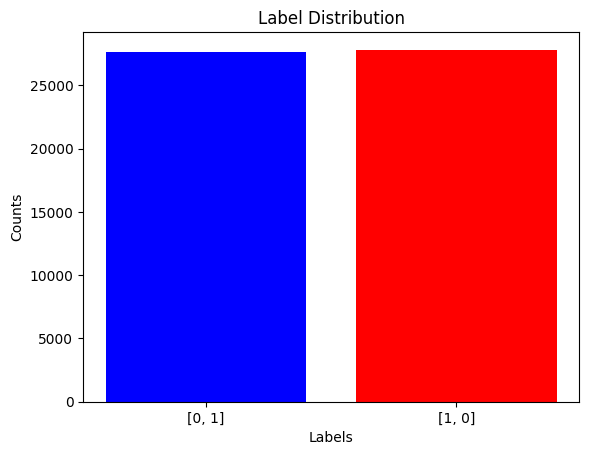

In [ ]:

# 레이블 분포 확인
label_counts = np.sum(train_y, axis=0)
print("Label counts:", label_counts)
print(f"Count of [0, 1]: {label_counts[1]}")
print(f"Count of [1, 0]: {label_counts[0]}")

# 퍼센티지로 분포 확인
total_count = len(train_y)
percent_label_01 = (label_counts[1] / total_count) * 100
percent_label_10 = (label_counts[0] / total_count) * 100

print(f"Percentage of [0, 1]: {percent_label_01:.2f}%")
print(f"Percentage of [1, 0]: {percent_label_10:.2f}%")

# 시각화
import matplotlib.pyplot as plt

labels = ['[0, 1]', '[1, 0]']
counts = [label_counts[1], label_counts[0]]

plt.bar(labels, counts, color=['blue', 'red'])
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

class BCEDiceLoss(nn.Module):
    def __init__(self, weight_bce=0.5, weight_dice=0.5):
        super(BCEDiceLoss, self).__init__()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        self.bce = nn.BCELoss()

    def forward(self, logits, targets):
        # BCE Loss
        bce_loss = self.bce(logits, targets)

        # Dice Loss
        smooth = 1e-5
        logits = logits.contiguous()
        targets = targets.contiguous()

        intersection = (logits * targets).sum(dim=1)
        union = logits.sum(dim=1) + targets.sum(dim=1)

        dice_loss = 1 - ((2. * intersection + smooth) / (union + smooth)).mean()

        # Combined Loss
        combined_loss = self.weight_bce * bce_loss + self.weight_dice * dice_loss
        return combined_loss

# Update the train function to use BCEDiceLoss
def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.BCELoss().to(device)

    best_score = 100
    best_model = None

    for epoch in range(1, CONFIG.N_EPOCHS+1):
        model.train()
        train_loss = []
        for features, labels in tqdm(iter(train_loader)):
            features = features.float().to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()

            output = model(features)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        _val_loss, _val_auc, _val_brier, _val_ece, _val_combined = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val AUC : [{_val_auc:.5f}] Val Brier : [{_val_brier:.5f}] Val ECE : [{_val_ece:.5f}] Val Combined Score : [{_val_combined:.5f}]')
        if best_score > _val_combined:
            best_score = _val_combined
            best_model = model

    return best_model

def multiLabel_AUC(y_true, y_scores):
    auc_scores = []
    for i in range(y_true.shape[1]):
        auc = roc_auc_score(y_true[:, i], y_scores[:, i])
        auc_scores.append(auc)
    mean_auc_score = np.mean(auc_scores)
    return mean_auc_score

def expected_calibration_error(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    bin_totals = np.histogram(y_prob, bins=np.linspace(0, 1, n_bins + 1), density=False)[0]
    non_empty_bins = bin_totals > 0
    bin_weights = bin_totals / len(y_prob)
    bin_weights = bin_weights[non_empty_bins]
    prob_true = prob_true[:len(bin_weights)]
    prob_pred = prob_pred[:len(bin_weights)]
    ece = np.sum(bin_weights * np.abs(prob_true - prob_pred))
    return ece

def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for features, labels in tqdm(iter(val_loader)):
            features = features.float().to(device)
            labels = labels.float().to(device)

            probs = model(features)

            loss = criterion(probs, labels)

            val_loss.append(loss.item())

            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

        _val_loss = np.mean(val_loss)

        all_labels = np.concatenate(all_labels, axis=0)
        all_probs = np.concatenate(all_probs, axis=0)

        # Calculate AUC score
        auc_score = multiLabel_AUC(all_labels, all_probs)

        # Calculate Brier Score
        brier_score = mean_squared_error(all_labels, all_probs)

        # Calculate ECE for each class and average them
        ece_scores = []
        for i in range(all_labels.shape[1]):
            ece = expected_calibration_error(all_labels[:, i], all_probs[:, i])
            ece_scores.append(ece)
        ece_score = np.mean(ece_scores)

        # Calculate combined score
        combined_score = 0.5 * (1 - auc_score) + 0.25 * brier_score + 0.25 * ece_score

    return _val_loss, auc_score, brier_score, ece_score, combined_score


In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for features in tqdm(iter(test_loader)):
            features = features.float().to(device)

            probs = model(features)

            probs  = probs.cpu().detach().numpy()
            predictions += probs.tolist()
    return predictions

In [ ]:
import numpy as np
import random

def generate_synthetic_data(features, labels, ratio=0.2):
    num_samples = features.shape[0]
    num_synthetic = int(num_samples * ratio)

    # 가짜 음성과 진짜 음성 데이터 분리
    fake_features = features[labels[:, 0] == 1]
    real_features = features[labels[:, 1] == 1]

    # 합성 데이터 생성
    synthetic_features = []
    synthetic_labels = []

    for _ in range(num_synthetic):
        # 랜덤하게 가짜 음성과 진짜 음성을 선택
        fake_sample = fake_features[random.randint(0, len(fake_features) - 1)]
        real_sample = real_features[random.randint(0, len(real_features) - 1)]

        # 가짜 음성과 진짜 음성을 일정 비율로 섞어서 합성
        alpha = random.uniform(0.3, 0.7)  # 일정 비율로 섞기 위한 가중치
        combined_sample1 = alpha * fake_sample + (1 - alpha) * real_sample
        combined_sample2 = (1 - alpha) * fake_sample + alpha * real_sample

        # 랜덤하게 가짜 음성이 앞에 오거나 진짜 음성이 앞에 오게 결정
        if random.random() < 0.5:
            combined_sample = combined_sample1
        else:
            combined_sample = combined_sample2

        synthetic_features.append(combined_sample)
        synthetic_labels.append([1, 1])  # 합성 데이터의 레이블 설정

    synthetic_features = np.array(synthetic_features)
    synthetic_labels = np.array(synthetic_labels)

    # 합성 데이터 추가
    augmented_features = np.concatenate((features, synthetic_features), axis=0)
    augmented_labels = np.concatenate((labels, synthetic_labels), axis=0)

    return augmented_features, augmented_labels


In [ ]:
# 예시 데이터 로드
audio_mels_train = np.load('/content/drive/MyDrive/DACON/audio_mels_train.npy')
train_y = np.load('/content/drive/MyDrive/DACON/train_y.npy', allow_pickle=True)

if len(train_y.shape) == 1 and len(train_y[0].shape) == 1:
    train_y = np.stack(train_y)

# 합성 데이터 생성
augmented_features, augmented_labels = generate_synthetic_data(audio_mels_train, train_y)

print("Original features shape:", audio_mels_train.shape)
print("Augmented features shape:", augmented_features.shape)
print("Original labels shape:", train_y.shape)
print("Augmented labels shape:", augmented_labels.shape)

Original features shape: (55438, 1, 32, 313)
Augmented features shape: (66525, 1, 32, 313)
Original labels shape: (55438, 2)
Augmented labels shape: (66525, 2)


In [ ]:
##기존 라벨 활용하면 되나??

# 전체 데이터셋을 Train/Validation으로 나누기

from sklearn.model_selection import train_test_split

#X_train, X_valid, y_train, y_valid = train_test_split(augmented_features, augmented_labels, test_size=0.2, random_state=42)

#X_train, X_valid, y_train, y_valid = train_test_split(audio_mfcc_train, train_y, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(audio_mels_train, train_y, test_size=0.2, random_state=42)

#X_train, X_valid, _, _ = train_test_split(audio_mels_train, train_y, test_size=0.2, random_state=42)
#y_train=np.load('/content/drive/MyDrive/DACON/train_labels.npy')
#y_valid=np.load('/content/drive/MyDrive/DACON/val_labels.npy')

In [ ]:
# Assuming y_train and y_valid are the correct sizes
y_train = np.array(y_train)
y_valid = np.array(y_valid)

# Check the shape
print(y_train)
print(y_train[0])  # Should be (num_samples, 2)
print(y_valid.shape)  # Should be (num_samples, 2)

if len(y_train.shape) == 1 and len(y_train[0].shape) == 1:
    y_train = np.stack(y_train)
print("New shape of y_train:", y_train.shape)

if len(y_valid.shape) == 1 and len(y_valid[0].shape) == 1:
    y_valid = np.stack(y_valid)
print("New shape of y_valid:", y_valid.shape)

[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
[1. 0.]
(11088, 2)
New shape of y_train: (44350, 2)
New shape of y_valid: (11088, 2)


In [ ]:
# Train DataLoader 설정
train_dataset = CustomDataset(X=X_train, y=y_train)
train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)

# Validation DataLoader 설정
val_dataset = CustomDataset(X=X_valid, y=y_valid)
val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)

test_dataset= CustomDataset(X=audio_mels_test, y=None, train_mode=False)

#test_dataset= CustomDataset(X=audio_mfcc_test, y=None, train_mode=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)

#criterion = nn.BCELoss().to(device)

model=CNNMultiLabel()
optimizer = torch.optim.Adam(params=model.parameters(), lr=CONFIG.LR)
scheduler = None

In [ ]:
audio_mels_test.shape
y_train.shape

(44350, 2)

In [ ]:
infer_model = train(model, optimizer, train_loader, val_loader, device)

  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.24006] Val Loss : [0.07277] Val AUC : [0.99741] Val Brier : [0.02040] Val ECE : [0.01840] Val Combined Score : [0.01099]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.06120] Val Loss : [0.03322] Val AUC : [0.99935] Val Brier : [0.00882] Val ECE : [0.00646] Val Combined Score : [0.00414]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.03831] Val Loss : [0.05416] Val AUC : [0.99954] Val Brier : [0.01405] Val ECE : [0.02151] Val Combined Score : [0.00912]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.03036] Val Loss : [0.02232] Val AUC : [0.99972] Val Brier : [0.00486] Val ECE : [0.00402] Val Combined Score : [0.00236]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.02297] Val Loss : [0.01523] Val AUC : [0.99979] Val Brier : [0.00374] Val ECE : [0.00362] Val Combined Score : [0.00195]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.02158] Val Loss : [0.01431] Val AUC : [0.99983] Val Brier : [0.00369] Val ECE : [0.00152] Val Combined Score : [0.00139]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.01781] Val Loss : [0.02335] Val AUC : [0.99981] Val Brier : [0.00431] Val ECE : [0.00462] Val Combined Score : [0.00233]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.01565] Val Loss : [0.01396] Val AUC : [0.99982] Val Brier : [0.00339] Val ECE : [0.00347] Val Combined Score : [0.00181]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.01234] Val Loss : [0.01257] Val AUC : [0.99991] Val Brier : [0.00313] Val ECE : [0.00288] Val Combined Score : [0.00155]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.01106] Val Loss : [0.01244] Val AUC : [0.99994] Val Brier : [0.00212] Val ECE : [0.00194] Val Combined Score : [0.00105]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.01240] Val Loss : [0.03644] Val AUC : [0.99989] Val Brier : [0.00861] Val ECE : [0.01090] Val Combined Score : [0.00493]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.01766] Val Loss : [0.01255] Val AUC : [0.99995] Val Brier : [0.00301] Val ECE : [0.00333] Val Combined Score : [0.00161]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.01034] Val Loss : [0.01248] Val AUC : [0.99994] Val Brier : [0.00233] Val ECE : [0.00211] Val Combined Score : [0.00114]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.01047] Val Loss : [0.00940] Val AUC : [0.99995] Val Brier : [0.00205] Val ECE : [0.00187] Val Combined Score : [0.00100]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.00935] Val Loss : [0.01240] Val AUC : [0.99995] Val Brier : [0.00259] Val ECE : [0.00237] Val Combined Score : [0.00127]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.00951] Val Loss : [0.00555] Val AUC : [0.99998] Val Brier : [0.00144] Val ECE : [0.00109] Val Combined Score : [0.00064]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.00665] Val Loss : [0.01459] Val AUC : [0.99983] Val Brier : [0.00186] Val ECE : [0.00167] Val Combined Score : [0.00097]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.00776] Val Loss : [0.00453] Val AUC : [0.99999] Val Brier : [0.00142] Val ECE : [0.00130] Val Combined Score : [0.00068]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.00826] Val Loss : [0.00583] Val AUC : [0.99999] Val Brier : [0.00136] Val ECE : [0.00137] Val Combined Score : [0.00069]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.00593] Val Loss : [0.00799] Val AUC : [0.99998] Val Brier : [0.00164] Val ECE : [0.00123] Val Combined Score : [0.00073]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.00981] Val Loss : [0.01368] Val AUC : [0.99993] Val Brier : [0.00217] Val ECE : [0.00233] Val Combined Score : [0.00116]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.00601] Val Loss : [0.00886] Val AUC : [0.99995] Val Brier : [0.00117] Val ECE : [0.00112] Val Combined Score : [0.00060]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.00878] Val Loss : [0.00515] Val AUC : [0.99999] Val Brier : [0.00133] Val ECE : [0.00122] Val Combined Score : [0.00064]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.01097] Val Loss : [0.00826] Val AUC : [0.99999] Val Brier : [0.00148] Val ECE : [0.00130] Val Combined Score : [0.00070]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.00891] Val Loss : [0.00391] Val AUC : [0.99999] Val Brier : [0.00098] Val ECE : [0.00075] Val Combined Score : [0.00043]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.00822] Val Loss : [0.01754] Val AUC : [0.99989] Val Brier : [0.00175] Val ECE : [0.00186] Val Combined Score : [0.00096]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.00851] Val Loss : [0.03361] Val AUC : [0.99972] Val Brier : [0.00232] Val ECE : [0.00202] Val Combined Score : [0.00122]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.00324] Val Loss : [0.03567] Val AUC : [0.99975] Val Brier : [0.00147] Val ECE : [0.00149] Val Combined Score : [0.00086]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.01790] Val Loss : [0.00613] Val AUC : [0.99999] Val Brier : [0.00126] Val ECE : [0.00139] Val Combined Score : [0.00067]


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.00881] Val Loss : [0.00641] Val AUC : [0.99999] Val Brier : [0.00180] Val ECE : [0.00188] Val Combined Score : [0.00093]


In [ ]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/2084 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
%cd /content/drive/MyDrive/DACON
submit = pd.read_csv('./sample_submission.csv')
submit.head(3)

/content/drive/MyDrive/DACON


id  fake  real
0  TEST_00000     0     0
1  TEST_00001     0     0
2  TEST_00002     0     0

In [ ]:
submit.iloc[:, 1:] = preds

submit.head(10)

id          fake  real
0  TEST_00000  3.865128e-20   1.0
1  TEST_00001  1.786789e-25   1.0
2  TEST_00002  2.586209e-27   1.0
3  TEST_00003  0.000000e+00   1.0
4  TEST_00004  4.313119e-17   1.0
5  TEST_00005  0.000000e+00   1.0
6  TEST_00006  0.000000e+00   1.0
7  TEST_00007  0.000000e+00   1.0
8  TEST_00008  0.000000e+00   1.0
9  TEST_00009  0.000000e+00   1.0

In [ ]:
submit.to_csv('0709_mels_cnn_augmentation.csv', index=False)
# epoch = 6, batch_size = 96, n_mfcc = 32, n_mels = 32

# 분포

Preds statistics:
                  0             1
count  5.000000e+04  50000.000000
mean   4.837844e-02      0.951787
std    2.091280e-01      0.208301
min    0.000000e+00      0.000000
25%    0.000000e+00      1.000000
50%    2.049738e-28      1.000000
75%    1.162505e-17      1.000000
max    1.000000e+00      1.000000


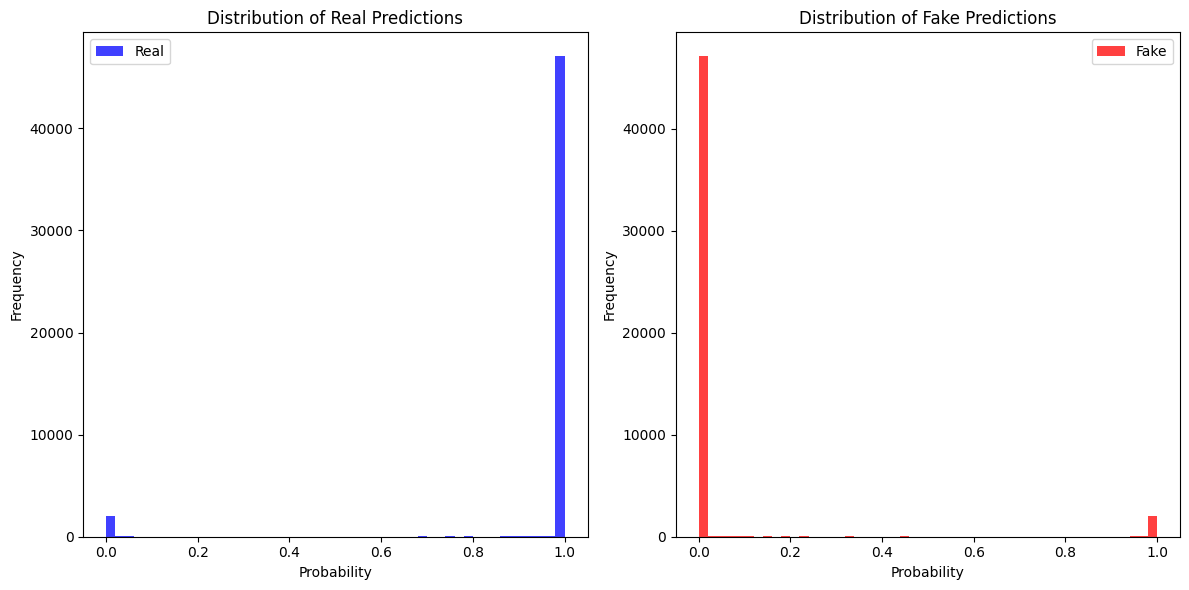


Fake label predictions:
Min: 0.0
Max: 1.0
Mean: 0.04837843884522741
Median: 2.0497381101209263e-28

Real label predictions:
Min: 0.0
Max: 1.0
Mean: 0.9517870131401017
Median: 1.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# preds가 리스트인 경우 numpy 배열로 변환
preds = np.array(preds)

# 예측값의 통계 정보 확인
print("Preds statistics:")
print(pd.DataFrame(preds).describe())

# 히스토그램으로 분포 시각화
plt.figure(figsize=(12, 6))

# Real 레이블의 분포
plt.subplot(1, 2, 1)
plt.hist(preds[:, 1], bins=50, alpha=0.75, color='blue', label='Real')
plt.title('Distribution of Real Predictions')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()

# Fake 레이블의 분포
plt.subplot(1, 2, 2)
plt.hist(preds[:, 0], bins=50, alpha=0.75, color='red', label='Fake')
plt.title('Distribution of Fake Predictions')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# preds를 DataFrame에 할당
submit.iloc[:, 1:] = preds

# 가짜 음성을 분류하지 못하는지 확인
fake_preds = preds[:, 0]
real_preds = preds[:, 1]

# Fake 레이블에 대한 기본 통계 확인
print("\nFake label predictions:")
print(f"Min: {fake_preds.min()}")
print(f"Max: {fake_preds.max()}")
print(f"Mean: {fake_preds.mean()}")
print(f"Median: {np.median(fake_preds)}")

# Real 레이블에 대한 기본 통계 확인
print("\nReal label predictions:")
print(f"Min: {real_preds.min()}")
print(f"Max: {real_preds.max()}")
print(f"Mean: {real_preds.mean()}")
print(f"Median: {np.median(real_preds)}")


In [ ]:
import IPython.display as ipd
import librosa
test=pd.read_csv('./test.csv')
train=pd.read_csv('./train.csv')
num=10
for i in range(num):
    y, sr=librosa.load(train['path'][i], sr=32000)
    print(i)
    ipd.display(ipd.Audio(data=y, rate=sr))

0


1


2


3


4


5


6


7


8


9
